# Gesture Recognition
In this group project, you are going to build a 3D Conv & CNN-RNN models that will be able to predict the 5 gestures correctly.

The dataset can be downloaded from here - https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

In [1]:
!nvidia-smi

Tue Dec 31 13:17:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                On  | 00000000:3F:00.0 Off |                  Off |
| 33%   26C    P8               8W / 260W |      0MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
import numpy as np
import os
from imageio.v2 import imread
import imageio
from PIL import Image, ImageFilter, ImageEnhance
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [22]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
# tf.set_random_seed(30) # deprecated
tf.random.set_seed(30)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [23]:
project_folder='/datasets/Project_data'

## Configration

In [24]:
train_doc = np.random.permutation(open(f'{project_folder}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{project_folder}/val.csv').readlines())
batch_size = 10 #experiment with the batch size
image_count = 30 # number of images to be used for each video
image_height=160
image_width=160
channels=3
num_classes=5 # number of classes
input_shape=(image_count,image_width,image_height,channels)
curr_dt_time = datetime.datetime.now()
train_path = f'{project_folder}/train'
val_path = f'{project_folder}/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs  
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [25]:
def one_batch_data(source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        # Determine the sequence length for the current batch
        seq_len = remaining_seq if remaining_seq else batch_size
        
        # Initialize arrays for batch data and labels
        batch_data = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))
        batch_labels = np.zeros((seq_len, num_classes))
        
        if augment: 
            # Initialize array for augmented batch data
            batch_data_aug = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))

        # Process each folder (video) in the batch
        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx): 
                # Read and resize the image
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                #image_resized = imresize(image, (self.image_height, self.image_width, 3))
                image_resized = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_AREA)
                
                
                # Normalize and add the image data to the batch
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
                
                if augment:
                    # Apply random transformations for augmentation
                    shifted = cv2.warpAffine(
                        image, 
                        np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                        (image.shape[1], image.shape[0])
                    )
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]
                    #image_resized = imresize(cropped, (self.image_height, self.image_width, 3))
                    image_resized = cv2.resize(cropped, (image_width, image_height), interpolation=cv2.INTER_AREA)
                    
                    # Normalize and add the augmented image data
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
            
            # Assign one-hot encoded labels to the batch
            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
        
        if augment:
            # Concatenate original and augmented data/labels
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels

In [26]:
def generator(source_path, folder_list, batch_size, augment=False):
    #img_idx = [x for x in range(0, image_count) if x % 2 != 0]
    #print('Source path =', source_path, '; batch size =', batch_size, '; img_ix =', img_idx)
    img_idx = [x for x in range(0, image_count)]
    img_idx = img_idx[5:25] # middle 20 frames
    print('Source path =', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data, batch_labels = one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
            yield batch_data, batch_labels

        # Handle the remaining sequences if any (not forming a full batch)
        remaining_seq = len(t) % batch_size
        if remaining_seq != 0:
            batch_data, batch_labels = one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
            yield batch_data, batch_labels    


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
def create_model_config(name):
    model_name = name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)

    callbacks_list = [checkpoint, LR, early_stopping]
    return callbacks_list

In [28]:
def calculate_steps_per_epoch():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

In [52]:
# Ensure that the number of epochs is consistent with the history data
def plot_evaluation_graph(history):
    num_epochs = len(history.history['loss'])

    plt.figure(figsize=(10,10))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,GRU,GlobalAveragePooling2D,LSTM,MaxPool2D,ConvLSTM2D,GlobalAveragePooling1D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
# from keras.applications import MobileNet

### First Experiment - Conv3D Without Data Augmentation

In [54]:
model1 = Sequential()
model1.add(Conv3D(16, (3, 3, 3), padding='same',
          input_shape=input_shape))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(32, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(64, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(128, (2, 2, 2), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(Dense(64,activation='relu'))

model1.add(Dense(num_classes,activation='softmax'))

In [56]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 20 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=False)
val_generator = generator(val_path, val_doc, batch_size, augment=False)

callbacks_list = create_model_config('model_1')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [77]:
optimiser = 'Adam' #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_17 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_18 (Activation)  (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                                 

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [58]:
history1=model1.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5964 - categorical_accuracy: 0.2293Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.53910, saving model to model_1_2024-12-3114_11_23.804348/model-00001-1.59641-0.22926-1.53910-0.23000.keras
34/34 [==============================] - 49s 1s/step - loss: 1.5964 - categorical_accuracy: 0.2293 - val_loss: 1.5391 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.3363
Epoch 00002: val_loss improved from 1.53910 to 1.53364, saving model to model_1_2024-12-3114_11_23.804348/model-00002-1.43472-0.33635-1.53364-0.32000.keras
34/34 [==============================] - 49s 1s/step - loss: 1.4347 - categorical_accuracy: 0.3363 - val_loss: 1.5336 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
33/34 [==========

<Figure size 720x720 with 0 Axes>

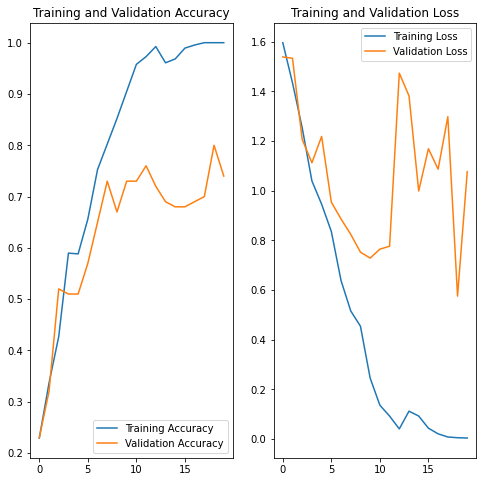

In [59]:
plot_evaluation_graph(history1)

### Second Experiment - Conv3D with Data Augmentation

In [60]:
model2 = Sequential()
model2.add(Conv3D(16, (3, 3, 3), padding='same',
          input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (2, 2, 2), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))

model2.add(Dense(num_classes,activation='softmax'))

In [61]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 20 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size, augment=True)

callbacks_list = create_model_config('model_2')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


In [78]:
optimiser = 'Adam' #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_22 (Activation)  (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                                 

In [63]:
history2=model2.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6149 - categorical_accuracy: 0.2066Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.54266, saving model to model_2_2024-12-3114_11_23.804348/model-00001-1.61494-0.20664-1.54266-0.42500.keras
34/34 [==============================] - 142s 4s/step - loss: 1.6149 - categorical_accuracy: 0.2066 - val_loss: 1.5427 - val_categorical_accuracy: 0.4250 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4625 - categorical_accuracy: 0.3537
Epoch 00002: val_loss improved from 1.54266 to 1.39623, saving model to model_2_2024-12-3114_11_23.804348/model-00002-1.46251-0.35370-1.39623-0.34500.keras
34/34 [==============================] - 136s 4s/step - loss: 1.4625 - categorical_accuracy: 0.3537 - val_loss: 1.3962 - val_categorical_accuracy: 0.3450 - lr: 0.0010
Epoch 3/20
34/34 [========

<Figure size 720x720 with 0 Axes>

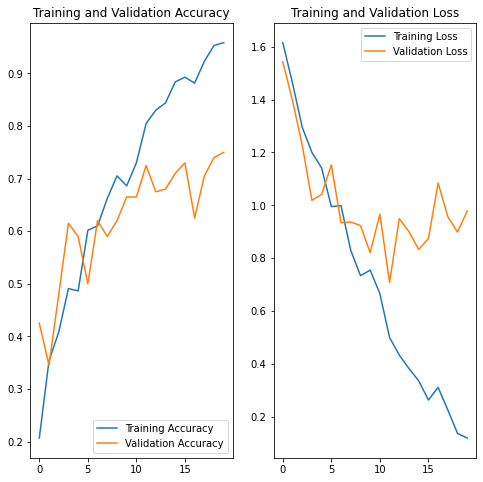

In [64]:
plot_evaluation_graph(history2)

### Thrid Experiment - Conv3D with Data Augmentation and additional Layer

In [80]:
model3 = Sequential()
model3.add(Conv3D(8, (2, 2, 2), padding='same',
          input_shape=input_shape))
model3.add(Activation('relu'))

model3.add(Conv3D(16, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, (2, 2, 2), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(Dense(64,activation='relu'))

model3.add(Dense(num_classes,activation='softmax'))

In [81]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 25 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size, augment=True)

callbacks_list = create_model_config('model_3')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


In [82]:
optimiser = 'Adam' #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_25 (Conv3D)          (None, 30, 160, 160, 8)   200       
                                                                 
 activation_25 (Activation)  (None, 30, 160, 160, 8)   0         
                                                                 
 conv3d_26 (Conv3D)          (None, 30, 160, 160, 16)  1040      
                                                                 
 activation_26 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_27 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                     

In [40]:
# history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=4, initial_epoch=0,max_queue_size=20)

# fit_generator is deprecated and will be removed in a future version. Using fit which supports generators.
history3=model3.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5964 - categorical_accuracy: 0.2443Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.59319, saving model to model_3_2024-12-3114_11_23.804348/model-00001-1.59641-0.24434-1.59319-0.39000.keras
34/34 [==============================] - 120s 4s/step - loss: 1.5964 - categorical_accuracy: 0.2443 - val_loss: 1.5932 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5078 - categorical_accuracy: 0.3100
Epoch 00002: val_loss improved from 1.59319 to 1.47162, saving model to model_3_2024-12-3114_11_23.804348/model-00002-1.50780-0.30995-1.47162-0.56500.keras
34/34 [==============================] - 108s 3s/step - loss: 1.5078 - categorical_accuracy: 0.3100 - val_loss: 1.4716 - val_categorical_accuracy: 0.5650 - lr: 0.0010
Epoch 3/25
34/34 [========

<Figure size 720x720 with 0 Axes>

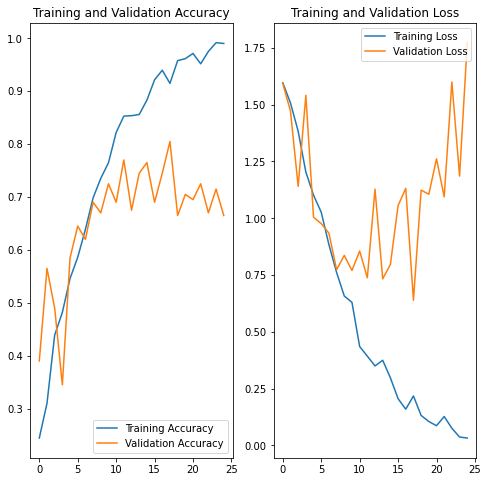

In [41]:
plot_evaluation_graph(history3)

### Fouth Experiment - CNN 2D and RNN (LSTM) with Data Augmentation

In [84]:
model4 = Sequential()
model4.add(TimeDistributed(Conv2D(8, (3,3), padding='same',activation='relu'),
         input_shape=(20,160,160,3)))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(16, (3,3), padding='same',activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(32, (3,3), padding='same',activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3,3), padding='same',activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(128, (3,3), padding='same',activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))

model4.add(LSTM(128))
model4.add(Dropout(0.5))

model4.add(Dense(128,activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(num_classes,activation='softmax'))


In [85]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 25 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size, augment=True)

callbacks_list = create_model_config('model_4')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


In [86]:
optimiser = 'Adam' #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 20, 160, 160, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 160, 160, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 20, 80, 80, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 20, 80, 80, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 20, 80, 80, 16) 

In [91]:
history4=model4.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.5939 - categorical_accuracy: 0.2964Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.87033, saving model to model_5_2024-12-3114_11_23.804348/model-00001-1.59393-0.29638-1.87033-0.18000.keras
34/34 [==============================] - 142s 4s/step - loss: 1.5939 - categorical_accuracy: 0.2964 - val_loss: 1.8703 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
33/34 [============================>.] - ETA: 3s - loss: 1.2921 - categorical_accuracy: 0.4477
Epoch 00002: val_loss improved from 1.87033 to 1.68093, saving model to model_5_2024-12-3114_11_23.804348/model-00002-1.29129-0.44796-1.68093-0.16500.keras
34/34 [==============================] - 134s 4s/step - loss: 1.2913 - categorical_accuracy: 0.4480 - val_loss: 1.6809 - val_categorical_accuracy: 0.1650 - lr: 0.0010
Epoch 3/15
34/34 [========

<Figure size 720x720 with 0 Axes>

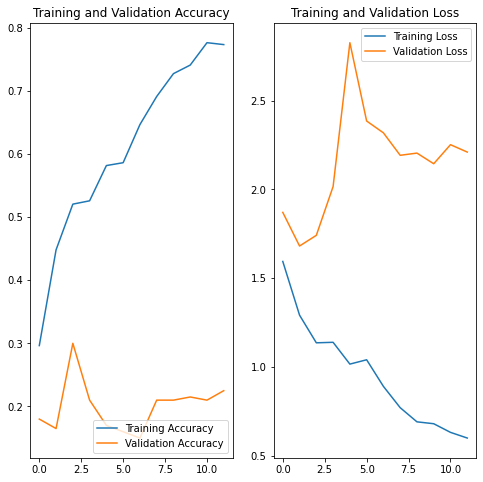

In [93]:
plot_evaluation_graph(history4)

### Fifth Experiment - CNN 2D and GRU with Data Augmentation

In [88]:
model5 = Sequential()
model5.add(TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'), input_shape=(20,160,160,3)))

model5.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))

model5.add(GRU(128))
model5.add(Dropout(0.5))

model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))

model5.add(Dense(num_classes, activation='softmax'))


In [89]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 15 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size, augment=True)

callbacks_list = create_model_config('model_5')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


In [90]:
optimiser = 'Adam' #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeDi  (None, 20, 160, 160, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 20, 160, 160, 16)  1168     
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 20, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 20, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 20, 80, 80, 32) 

In [50]:
# history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=4, initial_epoch=0,max_queue_size=20)

# fit_generator is deprecated and will be removed in a future version. Using fit which supports generators.
history5=model5.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8148 - categorical_accuracy: 0.2715Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.87839, saving model to model_5_2024-12-3114_11_23.804348/model-00001-1.81484-0.27149-2.87839-0.18000.keras
34/34 [==============================] - 110s 3s/step - loss: 1.8148 - categorical_accuracy: 0.2715 - val_loss: 2.8784 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.5637 - categorical_accuracy: 0.3152
Epoch 00002: val_loss improved from 2.87839 to 2.60284, saving model to model_5_2024-12-3114_11_23.804348/model-00002-1.56374-0.31523-2.60284-0.17000.keras
34/34 [==============================] - 106s 3s/step - loss: 1.5637 - categorical_accuracy: 0.3152 - val_loss: 2.6028 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
34/34 [========

<Figure size 720x720 with 0 Axes>

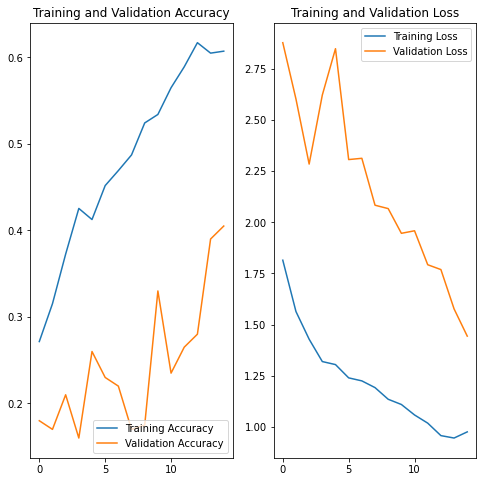

In [53]:
plot_evaluation_graph(history5)

### Sixth Experiment -   Transfer Learning with MobileNet pre trained model with Data Augmentation

In [72]:
from keras.applications import mobilenet

model6 = Sequential()
model6.add(TimeDistributed(mobilenet.MobileNet(weights='imagenet', include_top=False),input_shape=(20,160,160,3), name='mobilenet', trainable=False))
model6.add(TimeDistributed(BatchNormalization())) 
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Flatten()))

model6.add(GRU(128)) 
model6.add(Dropout(0.5))

model6.add(Dense(128,activation='relu')) 
model6.add(Dropout(0.5)) 
model6.add(Dense(num_classes, activation='softmax'))


In [73]:
batch_size = 20 #experiment with the batch size
image_count = 30 # number of images to be used for each video
num_epochs = 25 # choose the number of epochs  
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size, augment=True)

callbacks_list = create_model_config('model_6')
steps_per_epoch, validation_steps = calculate_steps_per_epoch()
print(f"Steps per epoch: {steps_per_epoch}") 
print(f"Validation steps: {validation_steps}")

Steps per epoch: 34
Validation steps: 5


In [74]:
optimiser = 'Adam' #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 160, 160, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 160, 160, 16)  1168     
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 80, 80, 32)  

In [75]:
history6=model6.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=callbacks_list,
                  validation_data=val_generator,
                  validation_steps=validation_steps,
                  class_weight=None,
                  batch_size=batch_size,
                  initial_epoch=0)

Source path = /datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6696 - categorical_accuracy: 0.3002Source path = /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.27002, saving model to model_6_2024-12-3114_11_23.804348/model-00001-1.66962-0.30015-1.27002-0.45000.keras
34/34 [==============================] - 158s 5s/step - loss: 1.6696 - categorical_accuracy: 0.3002 - val_loss: 1.2700 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1754 - categorical_accuracy: 0.5196
Epoch 00002: val_loss improved from 1.27002 to 0.93613, saving model to model_6_2024-12-3114_11_23.804348/model-00002-1.17540-0.51961-0.93613-0.61000.keras
34/34 [==============================] - 137s 4s/step - loss: 1.1754 - categorical_accuracy: 0.5196 - val_loss: 0.9361 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/25
34/34 [========

<Figure size 720x720 with 0 Axes>

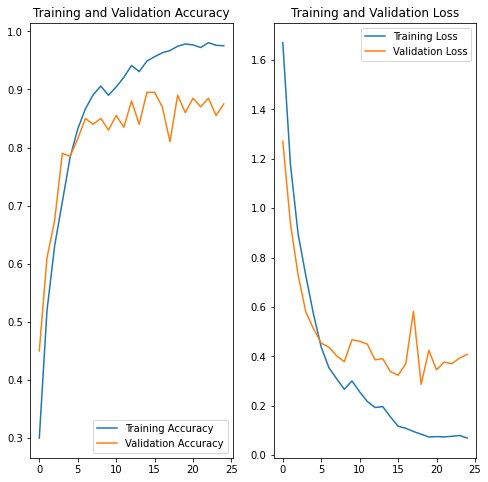

In [76]:
plot_evaluation_graph(history6)

### Select the best model from all experiment and final evaluation

In [102]:
from keras.models import load_model
 
# load model
model = load_model('model_3_2024-12-3114_11_23.804348/model-00018-0.21707-0.91478-0.63865-0.80500.keras') 
# Verify the model architecture 
model.build(input_shape)
# summarize model.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 8)   200       
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 8)   0         
                                                                 
 conv3d_13 (Conv3D)          (None, 30, 160, 160, 16)  1040      
                                                                 
 activation_13 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                      

In [103]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

50/50 [==============================] - 266s 5s/step - loss: 0.8659 - categorical_accuracy: 0.7300
evaluate categorical_accuracy: 73.00%
